## Pairs Of Adjacent Duplicates

Now that we have the first problem mostly working, let's try another.


Given a sequence of numbers, find and mark adjacent duplicates. For simplicity, we'll only have one duplicate in each input.

```
input  = 0 3 5 9 3 3 5 2 5
output = 0 0 0 0 1 1 0 0 0
```


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from radam import RAdam
from transformers import BertConfig, BertModel
from torch.utils.data import DataLoader, Dataset
from utils import train, get_accuracy, get_output_for_example, plot_losses

In [2]:
def generate_data(num_examples: int, seq_len: int, vocab_size: int):
    inputs = np.random.randint(0, vocab_size, size=(num_examples, seq_len))
    outputs = np.zeros_like(inputs)
    
    for i in range(len(inputs)):
        
        # choose number of duplicates to introduce
        num_duplicates = 2
        
        # choose random location to introduce our duplicates
        location = np.random.randint(0, len(inputs[i]) - num_duplicates)
        
        # Choose what number we'd like to repeat
        number_to_repeat = np.random.randint(0, vocab_size)
        
        inputs[i][location:location + num_duplicates] = number_to_repeat
        
        # Mark location where duplicates exist
        outputs[i][location:location + num_duplicates] = 1
        

    return inputs, outputs

In [3]:
# We're lazy so we're going to just use a large vocabulary 
# instead of manually removing accidental duplicates
generate_data(num_examples=1, seq_len=10, vocab_size=1000)

(array([[374, 490, 490, 547, 611, 594, 754, 115,   4, 883]]),
 array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]]))

In [4]:
class ToyDataset(Dataset):
   
    def __init__(self, num_examples, sequence_length, vocab_size):
        self.items, self.labels = generate_data(num_examples, sequence_length, vocab_size)
        
    def __getitem__(self, idx):
        
        x = torch.Tensor(self.items[idx]).long()
        y = torch.Tensor(self.labels[idx]).long()
        return x.cuda(), y.cuda()
    
    def __len__(self):
        return len(self.items)

In [5]:
class ToyModel(torch.nn.Module):
    """
    Wrapper around a BERT model that predicts a single binary output for each input token
    """
    
    def __init__(self, vocab_size):
        super().__init__()
        
        # Untrained BERT Model
        config = BertConfig(vocab_size_or_config_json_file=vocab_size)
        self.bert_model = BertModel(config)
        self.linear = torch.nn.Linear(in_features=768, out_features=2)
        
    def forward(self, x):    
        out, _ = self.bert_model(x)
        out = self.linear(out)
        return out    

In [6]:
TRN_EXAMPLES = 128
VAL_EXAMPLES = 120
SEQ_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [7]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [24]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=50, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.549916684627533
Epoch:	 0 			Valid Accuracy	 0.79348963
Epoch:	 1 	Step:	 0 	Loss:	 0.5504586100578308
Epoch:	 1 			Valid Accuracy	 0.8000001
Epoch:	 2 	Step:	 0 	Loss:	 0.5850911140441895
Epoch:	 2 			Valid Accuracy	 0.7893229
Epoch:	 3 	Step:	 0 	Loss:	 0.49532175064086914
Epoch:	 3 			Valid Accuracy	 0.79453135
Epoch:	 4 	Step:	 0 	Loss:	 0.46877628564834595
Epoch:	 4 			Valid Accuracy	 0.7984375
Epoch:	 5 	Step:	 0 	Loss:	 0.4457995295524597
Epoch:	 5 			Valid Accuracy	 0.76744795
Epoch:	 6 	Step:	 0 	Loss:	 0.4453398585319519
Epoch:	 6 			Valid Accuracy	 0.7963542
Epoch:	 7 	Step:	 0 	Loss:	 0.4241681694984436
Epoch:	 7 			Valid Accuracy	 0.7757813
Epoch:	 8 	Step:	 0 	Loss:	 0.4092821180820465
Epoch:	 8 			Valid Accuracy	 0.7945312
Epoch:	 9 	Step:	 0 	Loss:	 0.39121687412261963
Epoch:	 9 			Valid Accuracy	 0.7710938
Epoch:	 10 	Step:	 0 	Loss:	 0.3617556095123291
Epoch:	 10 			Valid Accuracy	 0.7861979
Epoch:	 11 	Step:	 0 	Loss:	 0.3348979949951172

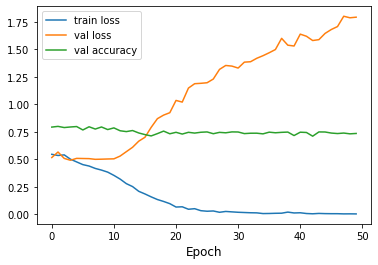

In [26]:
plot_losses(trn_loss, val_loss, val_acc)

Although we're getting low training loss, we've clearly overfit our dataset as validation loss has exploded. Additionally we're getting about 80% validation accuracy at best which is as much as we could expect when predicting all `0`. (80% of each example is `0`).

Let's try adding ten times as much training data.

In [34]:
# Ten times as much data as before
TRN_EXAMPLES = 1280
VAL_EXAMPLES = 1200
# Other parameters are kept the same
SEQ_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [35]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [36]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [37]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=50, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.6584423184394836
Epoch:	 0 			Valid Accuracy	 0.7999999
Epoch:	 1 	Step:	 0 	Loss:	 0.47321218252182007
Epoch:	 1 			Valid Accuracy	 0.799671
Epoch:	 2 	Step:	 0 	Loss:	 0.46234917640686035
Epoch:	 2 			Valid Accuracy	 0.79654604
Epoch:	 3 	Step:	 0 	Loss:	 0.4707900583744049
Epoch:	 3 			Valid Accuracy	 0.7849507
Epoch:	 4 	Step:	 0 	Loss:	 0.46136125922203064
Epoch:	 4 			Valid Accuracy	 0.7602796
Epoch:	 5 	Step:	 0 	Loss:	 0.4570659101009369
Epoch:	 5 			Valid Accuracy	 0.7592928
Epoch:	 6 	Step:	 0 	Loss:	 0.4252626895904541
Epoch:	 6 			Valid Accuracy	 0.7473685
Epoch:	 7 	Step:	 0 	Loss:	 0.3852044939994812
Epoch:	 7 			Valid Accuracy	 0.71422696
Epoch:	 8 	Step:	 0 	Loss:	 0.3179878294467926
Epoch:	 8 			Valid Accuracy	 0.7283717
Epoch:	 9 	Step:	 0 	Loss:	 0.3127977252006531
Epoch:	 9 			Valid Accuracy	 0.7277138
Epoch:	 10 	Step:	 0 	Loss:	 0.27355897426605225
Epoch:	 10 			Valid Accuracy	 0.7144737
Epoch:	 11 	Step:	 0 	Loss:	 0.3094567060470581

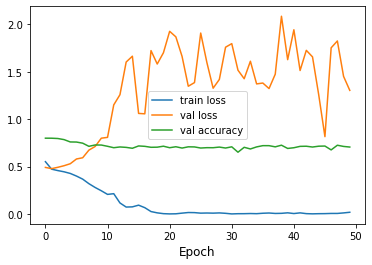

In [38]:
plot_losses(trn_loss, val_loss, val_acc)

We're still getting low training loss, but high validation loss and poor validation accuracy.

Let's try adding more data!

In [39]:
# 100x as much data as before
TRN_EXAMPLES = 12800
VAL_EXAMPLES = 1200
# Other parameters are kept the same
SEQ_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [40]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [41]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [42]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=10, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.844509482383728
Epoch:	 0 	Step:	 100 	Loss:	 0.4921850264072418
Epoch:	 0 	Step:	 200 	Loss:	 0.4671918749809265
Epoch:	 0 	Step:	 300 	Loss:	 0.4769051969051361
Epoch:	 0 			Valid Accuracy	 0.7999999
Epoch:	 1 	Step:	 0 	Loss:	 0.47771650552749634
Epoch:	 1 	Step:	 100 	Loss:	 0.481773316860199
Epoch:	 1 	Step:	 200 	Loss:	 0.45999717712402344
Epoch:	 1 	Step:	 300 	Loss:	 0.46936410665512085
Epoch:	 1 			Valid Accuracy	 0.7999999
Epoch:	 2 	Step:	 0 	Loss:	 0.48127609491348267
Epoch:	 2 	Step:	 100 	Loss:	 0.4805912375450134
Epoch:	 2 	Step:	 200 	Loss:	 0.45702213048934937
Epoch:	 2 	Step:	 300 	Loss:	 0.4726109504699707
Epoch:	 2 			Valid Accuracy	 0.7999999
Epoch:	 3 	Step:	 0 	Loss:	 0.4735395908355713
Epoch:	 3 	Step:	 100 	Loss:	 0.4819353520870209
Epoch:	 3 	Step:	 200 	Loss:	 0.442431777715683
Epoch:	 3 	Step:	 300 	Loss:	 0.47053855657577515
Epoch:	 3 			Valid Accuracy	 0.7999999
Epoch:	 4 	Step:	 0 	Loss:	 0.4508120119571686
Epoch:	 4 	Step:	 

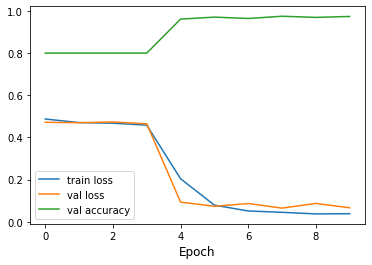

In [43]:
plot_losses(trn_loss, val_loss, val_acc)

So it looks like we need much more data in order to get our network to learn the solution. It also never quite reaches 100% accuracy. Perhaps lowering the learning rate would have helped at the end? 

Most of the learning seems to have happened between epochs 3 and 4.

## Longer Sequences

What happens when we increase the sequence length? Does the problem become harder? 

In [15]:
# 10x sequence length 
SEQ_LENGTH = 100
# Other parameters are kept the same (as the working version)
TRN_EXAMPLES = 12800
VAL_EXAMPLES = 1200
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [54]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [17]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=4, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 1.065748691558838
Epoch:	 0 	Step:	 100 	Loss:	 0.09806899726390839
Epoch:	 0 	Step:	 200 	Loss:	 0.09842109680175781
Epoch:	 0 	Step:	 300 	Loss:	 0.09795079380273819
Epoch:	 0 			Valid Accuracy	 0.97999996
Epoch:	 1 	Step:	 0 	Loss:	 0.09746132045984268
Epoch:	 1 	Step:	 100 	Loss:	 0.09707219153642654
Epoch:	 1 	Step:	 200 	Loss:	 0.09824276715517044
Epoch:	 1 	Step:	 300 	Loss:	 0.09879673272371292
Epoch:	 1 			Valid Accuracy	 0.97999996
Epoch:	 2 	Step:	 0 	Loss:	 0.09836908429861069
Epoch:	 2 	Step:	 100 	Loss:	 0.09824776649475098
Epoch:	 2 	Step:	 200 	Loss:	 0.09766499698162079
Epoch:	 2 	Step:	 300 	Loss:	 0.09872165322303772
Epoch:	 2 			Valid Accuracy	 0.97999996
Epoch:	 3 	Step:	 0 	Loss:	 0.09719438850879669
Epoch:	 3 	Step:	 100 	Loss:	 0.09796451777219772
Epoch:	 3 	Step:	 200 	Loss:	 0.0974418893456459
Epoch:	 3 	Step:	 300 	Loss:	 0.09790065139532089
Epoch:	 3 			Valid Accuracy	 0.97999996


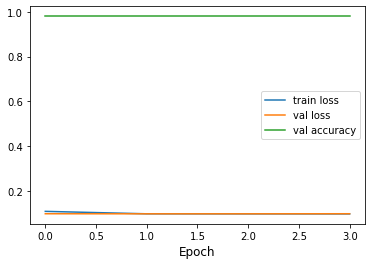

In [10]:
plot_losses(trn_loss, val_loss, val_acc)

So this looks surprisingly good. Despite having longer sequences we're achieving comparable or even better validation accuracy as in our previous example. But the truth is that we're being misled, let's take a look at an example from our **training set**.

In [11]:
# Check if we're learned how to perform on items in the train dataset
x, y = train_ds[0]
y_hat = get_output_for_example(model, x)

print("X:\t", x)
print("y:\t", y)
print("y_hat:\t", y_hat.squeeze())

X:	 tensor([497, 375, 957, 212, 170, 535, 740, 292, 758, 115, 808, 945,  37, 298,
        268, 673, 474, 467,  48, 536, 715, 892, 650, 925, 198, 105, 131, 288,
        206, 144,  73, 213, 397, 170, 495,  62, 880, 122, 392, 285, 975, 183,
        224, 321, 331, 485, 107, 560, 825, 204, 520, 695, 859, 595, 821, 338,
        869, 494, 747, 960,  54, 666,  65, 841, 824, 460, 737, 395,  37, 342,
        738, 738, 690, 747, 461, 952,  16,  72, 262, 976,  53, 309, 909, 740,
         17, 660, 845, 683,  96, 229,  69,  37, 985, 726, 646, 648, 334, 215,
        433, 220], device='cuda:0')
y:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
y_hat:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Our model has learned to output `0` for all positions which gives it a very low loss as well as a high accuracy.

Our validation accuracy is ~98% which makes sense because 98% of all outputs are `0`.

**TODO: How do we fix this? Focal Loss?**

## Focal Loss

Let's try using [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf).

> Our novel Focal Loss focuses training on a sparse set of hard examples and prevents the vast number of easy negatives from overwhelming the detector during training.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.alpha = torch.Tensor([alpha, 1 - alpha])
        self.size_average = size_average

    def forward(self, input, target):

        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [21]:
# 10x sequence length 
SEQ_LENGTH = 100
# Other parameters are kept the same (as the working version)
TRN_EXAMPLES = 12800
VAL_EXAMPLES = 1200
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [114]:
for a in [0.25, 0.5, 0.75, 0.9]:
    for g in [1, 2, 5, 10, 20, 50]:
        
        print()
        print(a, g)
        model = ToyModel(VOCAB_SIZE)
        model = model.cuda()
        optimizer = RAdam(model.parameters(), lr=LR)
        loss_fn = FocalLoss(gamma=g, alpha=a)
        trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=10, print_every=100)


0.25 1


/home/josh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch:	 0 	Step:	 0 	Loss:	 0.06355327367782593
Epoch:	 0 	Step:	 100 	Loss:	 0.031293246895074844
Epoch:	 0 	Step:	 200 	Loss:	 0.030473466962575912
Epoch:	 0 	Step:	 300 	Loss:	 0.03020532988011837
Epoch:	 0 			Valid Accuracy	 0.97999996
Epoch:	 1 	Step:	 0 	Loss:	 0.03026038594543934
Epoch:	 1 	Step:	 100 	Loss:	 0.030119257047772408
Epoch:	 1 	Step:	 200 	Loss:	 0.03018295206129551
Epoch:	 1 	Step:	 300 	Loss:	 0.030604461207985878
Epoch:	 1 			Valid Accuracy	 0.97999996
Epoch:	 2 	Step:	 0 	Loss:	 0.030097953975200653
Epoch:	 2 	Step:	 100 	Loss:	 0.030159911140799522
Epoch:	 2 	Step:	 200 	Loss:	 0.030336039140820503
Epoch:	 2 	Step:	 300 	Loss:	 0.03026892989873886
Epoch:	 2 			Valid Accuracy	 0.97999996
Epoch:	 3 	Step:	 0 	Loss:	 0.029794353991746902
Epoch:	 3 	Step:	 100 	Loss:	 0.02998814918100834
Epoch:	 3 	Step:	 200 	Loss:	 0.03024820238351822
Epoch:	 3 	Step:	 300 	Loss:	 0.030136512592434883
Epoch:	 3 			Valid Accuracy	 0.97999996
Epoch:	 4 	Step:	 0 	Loss:	 0.028880801

Epoch:	 3 			Valid Accuracy	 0.97999996
Epoch:	 4 	Step:	 0 	Loss:	 7.789798110025004e-05
Epoch:	 4 	Step:	 100 	Loss:	 7.566453132312745e-05
Epoch:	 4 	Step:	 200 	Loss:	 7.72170678828843e-05
Epoch:	 4 	Step:	 300 	Loss:	 7.567787542939186e-05
Epoch:	 4 			Valid Accuracy	 0.97999996
Epoch:	 5 	Step:	 0 	Loss:	 7.560307858511806e-05
Epoch:	 5 	Step:	 100 	Loss:	 7.726548938080668e-05
Epoch:	 5 	Step:	 200 	Loss:	 7.435993029503152e-05
Epoch:	 5 	Step:	 300 	Loss:	 7.744642061879858e-05
Epoch:	 5 			Valid Accuracy	 0.97999996
Epoch:	 6 	Step:	 0 	Loss:	 7.646730227861553e-05
Epoch:	 6 	Step:	 100 	Loss:	 7.617137453053147e-05
Epoch:	 6 	Step:	 200 	Loss:	 7.742660091025755e-05
Epoch:	 6 	Step:	 300 	Loss:	 7.766042836010456e-05
Epoch:	 6 			Valid Accuracy	 0.97999996
Epoch:	 7 	Step:	 0 	Loss:	 7.64544092817232e-05
Epoch:	 7 	Step:	 100 	Loss:	 7.500730134779587e-05
Epoch:	 7 	Step:	 200 	Loss:	 7.559012738056481e-05
Epoch:	 7 	Step:	 300 	Loss:	 7.718690176261589e-05
Epoch:	 7 			Valid

Epoch:	 7 	Step:	 100 	Loss:	 0.025706419721245766
Epoch:	 7 	Step:	 200 	Loss:	 0.02599986083805561
Epoch:	 7 	Step:	 300 	Loss:	 0.026483148336410522
Epoch:	 7 			Valid Accuracy	 0.97999996
Epoch:	 8 	Step:	 0 	Loss:	 0.02530304528772831
Epoch:	 8 	Step:	 100 	Loss:	 0.025322960689663887
Epoch:	 8 	Step:	 200 	Loss:	 0.026116466149687767
Epoch:	 8 	Step:	 300 	Loss:	 0.026376737281680107
Epoch:	 8 			Valid Accuracy	 0.97999996
Epoch:	 9 	Step:	 0 	Loss:	 0.025840088725090027
Epoch:	 9 	Step:	 100 	Loss:	 0.024533485993742943
Epoch:	 9 	Step:	 200 	Loss:	 0.0255404282361269
Epoch:	 9 	Step:	 300 	Loss:	 0.026015667244791985
Epoch:	 9 			Valid Accuracy	 0.97999996

0.5 2
Epoch:	 0 	Step:	 0 	Loss:	 0.10018294304609299
Epoch:	 0 	Step:	 100 	Loss:	 0.01541371550410986
Epoch:	 0 	Step:	 200 	Loss:	 0.015286731533706188
Epoch:	 0 	Step:	 300 	Loss:	 0.01506084855645895
Epoch:	 0 			Valid Accuracy	 0.97999996
Epoch:	 1 	Step:	 0 	Loss:	 0.014915461651980877
Epoch:	 1 	Step:	 100 	Loss:	 0.

Epoch:	 0 			Valid Accuracy	 0.81050986
Epoch:	 1 	Step:	 0 	Loss:	 8.357553156201902e-07
Epoch:	 1 	Step:	 100 	Loss:	 1.185572500617127e-06
Epoch:	 1 	Step:	 200 	Loss:	 1.2188603477625293e-06
Epoch:	 1 	Step:	 300 	Loss:	 1.0914271797446418e-06
Epoch:	 1 			Valid Accuracy	 0.8278536
Epoch:	 2 	Step:	 0 	Loss:	 6.795280569349416e-07
Epoch:	 2 	Step:	 100 	Loss:	 1.0412363735667896e-06
Epoch:	 2 	Step:	 200 	Loss:	 1.1116173936898122e-06
Epoch:	 2 	Step:	 300 	Loss:	 8.544099614482548e-07
Epoch:	 2 			Valid Accuracy	 0.8376562
Epoch:	 3 	Step:	 0 	Loss:	 5.399464839683787e-07
Epoch:	 3 	Step:	 100 	Loss:	 5.091142156743445e-07
Epoch:	 3 	Step:	 200 	Loss:	 6.456002097365854e-07
Epoch:	 3 	Step:	 300 	Loss:	 6.621511374760303e-07
Epoch:	 3 			Valid Accuracy	 0.8451481
Epoch:	 4 	Step:	 0 	Loss:	 6.601227369174012e-07
Epoch:	 4 	Step:	 100 	Loss:	 5.302244971971959e-07
Epoch:	 4 	Step:	 200 	Loss:	 5.579763069363253e-07
Epoch:	 4 	Step:	 300 	Loss:	 5.912812071073859e-07
Epoch:	 4 			Va

Epoch:	 4 	Step:	 200 	Loss:	 0.009740148670971394
Epoch:	 4 	Step:	 300 	Loss:	 0.00971137173473835
Epoch:	 4 			Valid Accuracy	 0.97999996
Epoch:	 5 	Step:	 0 	Loss:	 0.00956396572291851
Epoch:	 5 	Step:	 100 	Loss:	 0.00966781098395586
Epoch:	 5 	Step:	 200 	Loss:	 0.009646846912801266
Epoch:	 5 	Step:	 300 	Loss:	 0.009775400161743164
Epoch:	 5 			Valid Accuracy	 0.97999996
Epoch:	 6 	Step:	 0 	Loss:	 0.009432363323867321
Epoch:	 6 	Step:	 100 	Loss:	 0.00961439311504364
Epoch:	 6 	Step:	 200 	Loss:	 0.009638329967856407
Epoch:	 6 	Step:	 300 	Loss:	 0.00974886491894722
Epoch:	 6 			Valid Accuracy	 0.97999996
Epoch:	 7 	Step:	 0 	Loss:	 0.009409024380147457
Epoch:	 7 	Step:	 100 	Loss:	 0.009684634394943714
Epoch:	 7 	Step:	 200 	Loss:	 0.00961338821798563
Epoch:	 7 	Step:	 300 	Loss:	 0.009733595885336399
Epoch:	 7 			Valid Accuracy	 0.97999996
Epoch:	 8 	Step:	 0 	Loss:	 0.009287755005061626
Epoch:	 8 	Step:	 100 	Loss:	 0.009608713909983635
Epoch:	 8 	Step:	 200 	Loss:	 0.009524

Epoch:	 7 			Valid Accuracy	 0.97631586
Epoch:	 8 	Step:	 0 	Loss:	 1.1333272453839527e-07
Epoch:	 8 	Step:	 100 	Loss:	 1.120401051935005e-07
Epoch:	 8 	Step:	 200 	Loss:	 1.0554877860613487e-07
Epoch:	 8 	Step:	 300 	Loss:	 1.0808712147536426e-07
Epoch:	 8 			Valid Accuracy	 0.9766119
Epoch:	 9 	Step:	 0 	Loss:	 1.0947848494424761e-07
Epoch:	 9 	Step:	 100 	Loss:	 1.0513817727542119e-07
Epoch:	 9 	Step:	 200 	Loss:	 9.991135385689631e-08
Epoch:	 9 	Step:	 300 	Loss:	 1.063578736193449e-07
Epoch:	 9 			Valid Accuracy	 0.9774425

0.75 50
Epoch:	 0 	Step:	 0 	Loss:	 0.0006129413959570229
Epoch:	 0 	Step:	 100 	Loss:	 6.289033877004968e-11
Epoch:	 0 	Step:	 200 	Loss:	 1.5916322426701157e-10
Epoch:	 0 	Step:	 300 	Loss:	 2.15200746112032e-10
Epoch:	 0 			Valid Accuracy	 0.95142275
Epoch:	 1 	Step:	 0 	Loss:	 1.2359568923869801e-10
Epoch:	 1 	Step:	 100 	Loss:	 3.9979092258946025e-10
Epoch:	 1 	Step:	 200 	Loss:	 6.137069741285472e-10
Epoch:	 1 	Step:	 300 	Loss:	 7.509217136991708e-10
Ep

Epoch:	 1 	Step:	 200 	Loss:	 0.0009677972993813455
Epoch:	 1 	Step:	 300 	Loss:	 0.0009546024375595152
Epoch:	 1 			Valid Accuracy	 0.97999996
Epoch:	 2 	Step:	 0 	Loss:	 0.0009586763917468488
Epoch:	 2 	Step:	 100 	Loss:	 0.000953031238168478
Epoch:	 2 	Step:	 200 	Loss:	 0.0009400275885127485
Epoch:	 2 	Step:	 300 	Loss:	 0.0009329316089861095
Epoch:	 2 			Valid Accuracy	 0.97999996
Epoch:	 3 	Step:	 0 	Loss:	 0.000929031812120229
Epoch:	 3 	Step:	 100 	Loss:	 0.0009357371018268168
Epoch:	 3 	Step:	 200 	Loss:	 0.0009505693451501429
Epoch:	 3 	Step:	 300 	Loss:	 0.0009408096084371209
Epoch:	 3 			Valid Accuracy	 0.97999996
Epoch:	 4 	Step:	 0 	Loss:	 0.0009264994878321886
Epoch:	 4 	Step:	 100 	Loss:	 0.0009194259764626622
Epoch:	 4 	Step:	 200 	Loss:	 0.000935243209823966
Epoch:	 4 	Step:	 300 	Loss:	 0.0009416836546733975
Epoch:	 4 			Valid Accuracy	 0.97999996
Epoch:	 5 	Step:	 0 	Loss:	 0.0009210589341819286
Epoch:	 5 	Step:	 100 	Loss:	 0.0009175076265819371
Epoch:	 5 	Step:	 2

Epoch:	 4 	Step:	 300 	Loss:	 1.8041843019567239e-10
Epoch:	 4 			Valid Accuracy	 0.8444243
Epoch:	 5 	Step:	 0 	Loss:	 1.029386090256601e-10
Epoch:	 5 	Step:	 100 	Loss:	 1.676114802506845e-11
Epoch:	 5 	Step:	 200 	Loss:	 9.0619022702354e-12
Epoch:	 5 	Step:	 300 	Loss:	 8.706316917406198e-12
Epoch:	 5 			Valid Accuracy	 0.8176563
Epoch:	 6 	Step:	 0 	Loss:	 1.5013596268986795e-11
Epoch:	 6 	Step:	 100 	Loss:	 5.817860949941522e-12
Epoch:	 6 	Step:	 200 	Loss:	 9.286383294282441e-12
Epoch:	 6 	Step:	 300 	Loss:	 6.624714665726117e-11
Epoch:	 6 			Valid Accuracy	 0.79983544
Epoch:	 7 	Step:	 0 	Loss:	 1.5760380500662308e-10
Epoch:	 7 	Step:	 100 	Loss:	 6.521275186521791e-11
Epoch:	 7 	Step:	 200 	Loss:	 4.346452017744973e-11
Epoch:	 7 	Step:	 300 	Loss:	 1.2966300776129369e-11
Epoch:	 7 			Valid Accuracy	 0.7723108
Epoch:	 8 	Step:	 0 	Loss:	 6.749664716032555e-11
Epoch:	 8 	Step:	 100 	Loss:	 3.2446524633744644e-11
Epoch:	 8 	Step:	 200 	Loss:	 1.2938303206588841e-11
Epoch:	 8 	Step

We can plot these results in a chart with alpha across the top and gamma across the side.


|   gamma   | 0.25 | 0.50 | 0.75 | 0.90 |
| --------- |:----:|:----:|:- --:|:----:|
| 1.00      | 0.98 | 0.98 | 0.98 | 0.98 |
| 2.00      | 0.98 | 0.98 | 0.98 | 0.98 |
| 5.00      | 0.98 | 0.98 | 0.98 | 0.98 |
| 10.0      | 0.98 | 0.98 | 0.98 | 0.98 |
| 20.0      | 0.88 | 0.88 | 0.98 | 0.98 |
| 50.0      | 0.63 | 0.72 | 0.85 | 0.77 |





Unfortunately, nothing seems to do that well. Let's investigate `gamma=20` and `alpha=0.25`.

In [22]:
a = 0.25
g = 20
        
print()
print(a, g)
model = ToyModel(VOCAB_SIZE)
model = model.cuda()
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = FocalLoss(gamma=g, alpha=a)
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=20, print_every=100)


0.25 20


/home/josh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch:	 0 	Step:	 0 	Loss:	 0.00015222532965708524
Epoch:	 0 	Step:	 100 	Loss:	 1.2361989547571284e-06
Epoch:	 0 	Step:	 200 	Loss:	 7.249186069202551e-07
Epoch:	 0 	Step:	 300 	Loss:	 6.218057819751266e-07
Epoch:	 0 			Valid Accuracy	 0.7431414
Epoch:	 1 	Step:	 0 	Loss:	 3.820464087311848e-07
Epoch:	 1 	Step:	 100 	Loss:	 2.570633057530358e-07
Epoch:	 1 	Step:	 200 	Loss:	 3.08966264128685e-07
Epoch:	 1 	Step:	 300 	Loss:	 2.2850794323403534e-07
Epoch:	 1 			Valid Accuracy	 0.806949
Epoch:	 2 	Step:	 0 	Loss:	 2.8916059591210796e-07
Epoch:	 2 	Step:	 100 	Loss:	 2.0727487992644456e-07
Epoch:	 2 	Step:	 200 	Loss:	 2.124137949977012e-07
Epoch:	 2 	Step:	 300 	Loss:	 1.5737379044367117e-07
Epoch:	 2 			Valid Accuracy	 0.8666695
Epoch:	 3 	Step:	 0 	Loss:	 2.3050748154673784e-07
Epoch:	 3 	Step:	 100 	Loss:	 1.7288948583882302e-07
Epoch:	 3 	Step:	 200 	Loss:	 1.8109530230958626e-07
Epoch:	 3 	Step:	 300 	Loss:	 1.6186720586119918e-07
Epoch:	 3 			Valid Accuracy	 0.8027384
Epoch:	 4 	S

In [31]:
# Check if we're learned how to perform on items in the train dataset
x, y = train_ds[7]
y_hat = get_output_for_example(model, x)

print("X:\t", x)
print("y:\t", y)
print("y_hat:\t", y_hat.squeeze())

X:	 tensor([866,  60, 960,   9, 750, 212,  37,  57, 561, 385,  99, 502, 205, 343,
        119, 210, 210, 329, 302, 850, 325, 642, 382, 435, 859, 698, 288, 729,
        652, 818, 300, 339, 255, 320,  23, 225, 199, 430, 941, 569, 367,  91,
        231, 269, 538, 138, 164, 902, 356, 219, 901, 502, 639, 214, 650, 272,
        762, 686, 776, 387, 529, 702, 457, 927, 941, 674, 119, 504, 651, 572,
        321, 683, 417, 688, 426, 142, 699, 284, 198, 819, 813,  80,  94,  56,
         75, 786, 234, 845, 529, 989, 520, 483, 281, 160, 199, 513, 751, 710,
        813, 419], device='cuda:0')
y:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
y_hat:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Train on Easy then Hard

In [7]:
# 10x sequence length 
SEQ_LENGTH = 10
# Other parameters are kept the same (as the working version)
TRN_EXAMPLES = 12800
VAL_EXAMPLES = 1200
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [8]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [9]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=15, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.5315520167350769
Epoch:	 0 	Step:	 100 	Loss:	 0.4702341556549072
Epoch:	 0 	Step:	 200 	Loss:	 0.4770457148551941
Epoch:	 0 	Step:	 300 	Loss:	 0.45787715911865234
Epoch:	 0 			Valid Accuracy	 0.7999999
Epoch:	 1 	Step:	 0 	Loss:	 0.4643818438053131
Epoch:	 1 	Step:	 100 	Loss:	 0.46619167923927307
Epoch:	 1 	Step:	 200 	Loss:	 0.47107166051864624
Epoch:	 1 	Step:	 300 	Loss:	 0.4638713002204895
Epoch:	 1 			Valid Accuracy	 0.7999999
Epoch:	 2 	Step:	 0 	Loss:	 0.4748496413230896
Epoch:	 2 	Step:	 100 	Loss:	 0.4667593836784363
Epoch:	 2 	Step:	 200 	Loss:	 0.4635048508644104
Epoch:	 2 	Step:	 300 	Loss:	 0.45223188400268555
Epoch:	 2 			Valid Accuracy	 0.7999999
Epoch:	 3 	Step:	 0 	Loss:	 0.46891745924949646
Epoch:	 3 	Step:	 100 	Loss:	 0.47200459241867065
Epoch:	 3 	Step:	 200 	Loss:	 0.4555718004703522
Epoch:	 3 	Step:	 300 	Loss:	 0.4463370442390442
Epoch:	 3 			Valid Accuracy	 0.80402964
Epoch:	 4 	Step:	 0 	Loss:	 0.39064958691596985
Epoch:	 4 	St

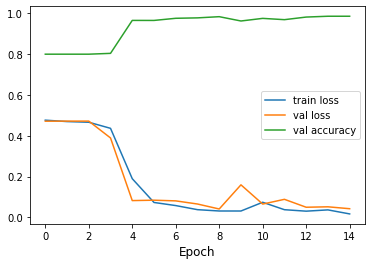

In [11]:
plot_losses(trn_loss, val_loss, val_acc)

In [12]:
# longer sequence
SEQ_LENGTH = 50
LR = 1e-5

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=15, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.5723610520362854
Epoch:	 0 	Step:	 100 	Loss:	 0.24527543783187866
Epoch:	 0 	Step:	 200 	Loss:	 0.17742981016635895
Epoch:	 0 	Step:	 300 	Loss:	 0.15349386632442474
Epoch:	 0 			Valid Accuracy	 0.96269727
Epoch:	 1 	Step:	 0 	Loss:	 0.1676495224237442
Epoch:	 1 	Step:	 100 	Loss:	 0.15921920537948608
Epoch:	 1 	Step:	 200 	Loss:	 0.15966863930225372
Epoch:	 1 	Step:	 300 	Loss:	 0.15610089898109436
Epoch:	 1 			Valid Accuracy	 0.96335524
Epoch:	 2 	Step:	 0 	Loss:	 0.16714531183242798
Epoch:	 2 	Step:	 100 	Loss:	 0.15680280327796936
Epoch:	 2 	Step:	 200 	Loss:	 0.14917729794979095
Epoch:	 2 	Step:	 300 	Loss:	 0.13923464715480804
Epoch:	 2 			Valid Accuracy	 0.963865
Epoch:	 3 	Step:	 0 	Loss:	 0.16859835386276245
Epoch:	 3 	Step:	 100 	Loss:	 0.15708529949188232
Epoch:	 3 	Step:	 200 	Loss:	 0.1525968760251999
Epoch:	 3 	Step:	 300 	Loss:	 0.14009685814380646
Epoch:	 3 			Valid Accuracy	 0.96432567
Epoch:	 4 	Step:	 0 	Loss:	 0.16682448983192444
Epoch

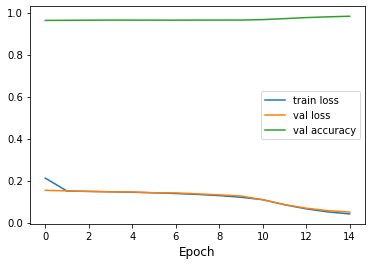

In [13]:
plot_losses(trn_loss, val_loss, val_acc)

In [14]:
# longer sequence
SEQ_LENGTH = 100
LR = 1e-5

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=15, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.09603872150182724
Epoch:	 0 	Step:	 100 	Loss:	 0.07081688195466995
Epoch:	 0 	Step:	 200 	Loss:	 0.06714370101690292
Epoch:	 0 	Step:	 300 	Loss:	 0.06236088275909424
Epoch:	 0 			Valid Accuracy	 0.9834868
Epoch:	 1 	Step:	 0 	Loss:	 0.07249600440263748
Epoch:	 1 	Step:	 100 	Loss:	 0.0618419349193573
Epoch:	 1 	Step:	 200 	Loss:	 0.06057404354214668
Epoch:	 1 	Step:	 300 	Loss:	 0.05587683618068695
Epoch:	 1 			Valid Accuracy	 0.9840048
Epoch:	 2 	Step:	 0 	Loss:	 0.06531830132007599
Epoch:	 2 	Step:	 100 	Loss:	 0.06416823714971542
Epoch:	 2 	Step:	 200 	Loss:	 0.05596213415265083
Epoch:	 2 	Step:	 300 	Loss:	 0.05949756130576134
Epoch:	 2 			Valid Accuracy	 0.9839721
Epoch:	 3 	Step:	 0 	Loss:	 0.06332319974899292
Epoch:	 3 	Step:	 100 	Loss:	 0.05213051661849022
Epoch:	 3 	Step:	 200 	Loss:	 0.04663209989666939
Epoch:	 3 	Step:	 300 	Loss:	 0.04573323577642441
Epoch:	 3 			Valid Accuracy	 0.984745
Epoch:	 4 	Step:	 0 	Loss:	 0.05720505863428116
Epoch:

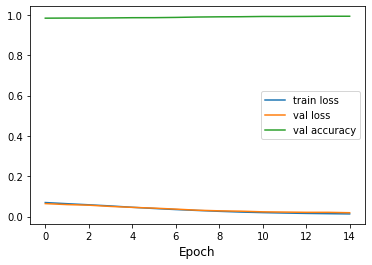

In [15]:
plot_losses(trn_loss, val_loss, val_acc)

In [18]:
# Check if we're learned how to perform on items in the train dataset
x, y = valid_ds[5]
y_hat = get_output_for_example(model, x)

print("X:\t", x)
print("y:\t", y)
print("y_hat:\t", y_hat.squeeze())

X:	 tensor([314, 360, 975, 770, 921, 419, 718,  76, 507, 941, 323, 273,  86, 447,
        275, 573, 479, 116, 274, 524, 240, 158, 616, 140, 683, 190, 889,  36,
        473, 510, 158, 339, 901,  32, 879, 270, 266, 575, 300, 223, 975, 777,
        754, 812, 817, 445, 868, 842, 613, 331, 733, 665, 563,  43,  90, 413,
        270, 208, 236, 565, 145, 865, 654, 154, 646, 166, 702, 303, 638, 121,
        707, 281, 952, 990, 719, 424, 108,   4, 983, 374, 499, 891, 710,  30,
         62, 969, 389, 373, 125, 283, 776, 408, 394, 323, 567, 567, 619, 299,
        595, 938], device='cuda:0')
y:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0], device='cuda:0')
y_hat:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

So this approach seems to work, but I'm still left feeling a little pessimistic about it. I can imagine problems where we cannot subdivide them into smaller sequences and then scale up the sequence length.

We still need a general solution.

One good thing is that we now know that there definitely exists some set of weights that allow a Transformer to solve this problem. The hard part seems to be getting our model to learn these weights directly!